In [1]:
from model import Model

model = Model()

model.eval()

/home/nisarg/anaconda3/envs/sd_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Model(
  (feature_extractor): EfficientNetFeatures(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (

In [3]:
import torch
from cityscapes import CityscapesDataModule

dm = CityscapesDataModule()
dm.setup()

In [30]:
confusion_matrix = torch.zeros(19, 19, dtype=torch.int64)

for batch in dm.val_dataloader():
    masks = batch[1]
    masks = masks[masks != 255]
    # print(torch.unique(masks))
    confusion_matrix += torch.bincount(19 * masks, minlength=19**2).view(19, 19)
    # break

In [31]:
confusion_matrix.sum(dim=1) / confusion_matrix.sum()

tensor([0.3795, 0.0540, 0.2135, 0.0070, 0.0083, 0.0149, 0.0020, 0.0067, 0.1744,
        0.0084, 0.0340, 0.0131, 0.0022, 0.0659, 0.0030, 0.0039, 0.0011, 0.0008,
        0.0072])

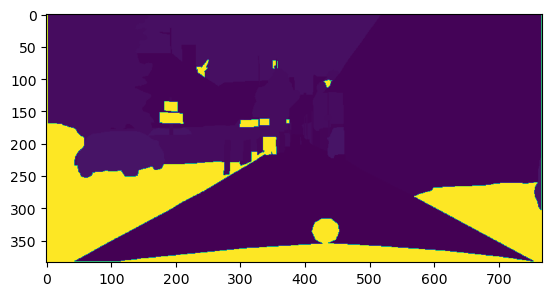

In [22]:
import matplotlib.pyplot as plt

plt.imshow(batch[1][0])

In [20]:
masks.shape

torch.Size([235583])

In [1]:
import os
import cv2
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from train import Network
from cityscapes import CityscapesDataModule


def process_mask(seg_mask, ds):
    # colored_mask = np.zeros((*image.shape[:2], 3), dtype=np.uint8)
    colored_mask = np.zeros((384, 768, 3), dtype=np.uint8)
    for id, color in enumerate(ds.COLOR_PALETTE):
        colored_mask[seg_mask == id] = ds.COLOR_PALETTE[color]

    return colored_mask


def process_bboxes(image, bboxes, labels, ds):
    for idx, bbox in enumerate(bboxes):
        bbox = bbox.numpy().astype(np.int32)
        label = (
            ds.LOCALIZATION_CLASSES[labels[idx].item()] + " " + str(labels[idx].item())
        )
        color = ds.COLOR_PALETTE[11 + labels[idx].item()]

        font_scale = 0.75
        thickness = 2

        image = cv2.rectangle(
            image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness
        )

        (w, h), _ = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness
        )
        image = cv2.rectangle(
            image, (bbox[0], bbox[1] - h - 10), (bbox[0] + w, bbox[1]), color, -1
        )
        image = cv2.putText(
            image,
            label,
            (bbox[0], bbox[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            [255, 255, 255],
            thickness,
        )

    return image


def get_detections(centerness, regression, score_threshold=0.25, topk=100):
    b, _, h, w = centerness.shape

    detections = []

    center_max = F.max_pool2d(centerness, kernel_size=3, stride=1, padding=1)
    center_mask = (center_max == centerness).float()
    centerness = centerness * center_mask

    for batch in range(b):

        scores, indices = torch.topk(centerness[batch].view(-1), k=topk)

        scores = scores[scores >= score_threshold]
        topk_indices = indices[: len(scores)]

        # print(len(scores))

        labels = (topk_indices / (h * w)).int()
        indices = topk_indices % (h * w)

        xs_orig = (indices % w).int()
        ys_orig = (indices / w).int()

        wh = regression[batch][:, ys_orig, xs_orig]

        half_w, half_h = wh[0] / 4, wh[1] / 4

        bboxes = (
            torch.stack(
                [
                    xs_orig - half_w,
                    ys_orig - half_h,
                    xs_orig + half_w,
                    ys_orig + half_h,
                ],
                dim=1,
            )
            * 4
        )

        detections.append([bboxes, scores, labels])

        return detections


dm = CityscapesDataModule()
dm.setup()

base_dir = "logs/cityscapes/version_28/checkpoints"

/home/nisarg/anaconda3/envs/sd_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


14


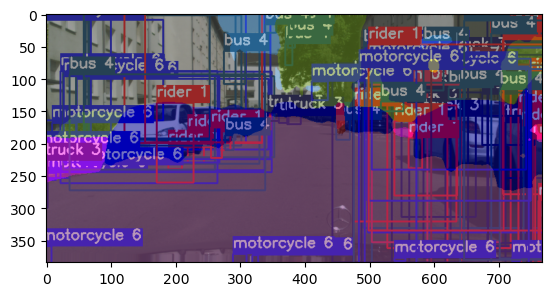

In [2]:
snapshot = torch.load(os.path.join(base_dir, os.listdir(base_dir)[0]))

print(snapshot["epoch"])

net = Network()
net.load_state_dict(snapshot["state_dict"])
net.eval()

with torch.no_grad():
    for idx, batch in enumerate(dm.val_dataloader()):
        if idx == 1:
            classifier, _, centerness, regression = net.model(batch[0])
            break

image = batch[0][0].numpy()
ds = dm.val_dataset
seg = classifier.argmax(dim=1)[0]
seg = process_mask(seg.numpy(), ds)

detections = get_detections(centerness, regression, score_threshold=0.8, topk=100)

inv_image = (
    (
        (
            (image * np.array((0.229, 0.224, 0.225)).reshape(3, 1, 1))
            + np.array((0.485, 0.456, 0.406)).reshape(3, 1, 1)
        )
        * 255
    )
    .transpose(1, 2, 0)
    .astype(np.uint8)
)
final = process_bboxes(inv_image.copy(), detections[0][0], detections[0][2], ds)

plt.imshow(final)
# plt.imshow(inv_image)
plt.imshow(seg, alpha=0.55)

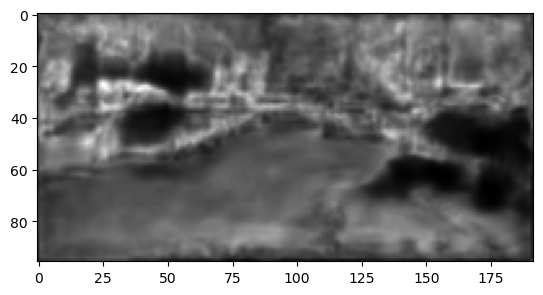

In [4]:
centerness = centerness.softmax(dim=1)
plt.imshow(centerness[0][2], cmap="gray")